# Análise do jogo político utilizando Dados Abertos

* Como entender objetivamente a dinâmica política?
* Extração de informações de votos com a API de Dados Abertos
* Preparação dos dados
* Visualização e interpretação dos dados
* Clusterização: medindo a coesão partidária
* Próximos passos

## Como entender objetivamente a dinâmica política?
![plenario](images/motivacao1.jpg)
![plenario](images/motivacao2.png)
![plenario](images/motivacao3.png)

### Estudo de referência: [Data Mining in Politics](http://www.stat.columbia.edu/~jakulin/Politics/) (EUA)

![Data Mining in Politics](images/politics-votes-us.png)

### Vantagens da análise por parlamentar
* Maior riqueza de informações
* Possibilita análise de apenas uma proposição
* Independe do número de partidos (permite comparar com os EUA, por exemplo)
* Responde à questão: Quantos e quais são os "reais" partidos?
* Permite analisar a coesão partidária

## Extração de informações de proposições da API de Dados Abertos

### O que é uma proposição?

Segundo o Art. 100 do Regimento Interno da Câmara dos Deputados:
![proposicao](images/proposicao.png)

### Entidades envolvidas

![entidades](images/entidades.png)

### Implementação das classes

In [232]:
import pandas as pd

class Votante:
    
    def __init__(self, id):
        self.id = id
        self.votos = {}
        
    def add_voto(self, voto, votacao):
        
        if self.votos is None:
            self.votos = {}
        
        self.votos[votacao.id] = voto
    
    def __repr__(self):
        return '%s - %s' % (self.id, self.votos)
    
    
class Deputado(Votante):
    
    def __repr__(self):
        return "%s - %s - %s" % (self.nome, self.partido, self.votos)
    
    
class Bancada(Votante):
    
    def __init__(self, id):
        self.id = id
        self.votos = {}
        self.sigla = ''
    
    def __repr__(self):
        return "Bancada_%s - %s" % (self.sigla, self.votos)


class Votacao:
    
    def __init__(self, id):
        self.id = id
        self.objeto = None
        self.data = None
        self.hora = None
        self.resumo = None
        
    def __repr__(self):
        return '%s - %s' % (self.id, self.resumo)

    
class Proposicao:
    
    def __init__(self, xml_root=None):
        
        self.votantes = {}
        self.votacoes = {}
        
        if xml:
            self.parse_xml(xml_root)
            
        else:
            self.votantes = {}
            self.sigla = None
            self.numero = None
            self.ano = None
    
    def __get_votante(self, id, tipo):
    
        if id in self.votantes:
            return self.votantes[id]

        elif tipo == 'Deputado':
            votante = Deputado(id)

        elif tipo == 'bancada':
            votante = Bancada(id)

        else:
            votante = Votante(id)

        self.votantes[id] = votante
        return votante
    
    def __get_votacao(self, id):
        
        if id in self.votacoes:
            return self.votacoes[id]
        else:
            votacao = Votacao(id)
        self.votacoes[id] = votacao
        return votacao
    
    def parse_xml(self, xml_root):
        
        for proposicao in xml_root:        
            #print(prop.tag, prop.attrib)
            
            if proposicao.tag == 'Sigla':
                self.sigla = proposicao.text
                
            if proposicao.tag == 'Numero':
                self.numero = proposicao.text
                
            if proposicao.tag == 'Ano':
                self.ano = proposicao.text
                
            for votacao in proposicao:
                #print(votacao.tag, votacao.text)
                _votacao = self.__get_votacao(votacao.attrib['ObjVotacao'])
                _votacao.cod_sessao = votacao.attrib['codSessao']
                _votacao.objeto = votacao.attrib['ObjVotacao']
                _votacao.data = votacao.attrib['Data']
                _votacao.hora = votacao.attrib['Hora']
                _votacao.resumo = votacao.attrib['Resumo']
                
                for tipos_votacao in votacao:
                    #print(tipos_votacao.tag, tipos_votacao.text)

                    for voto in tipos_votacao:

                        if voto.tag == 'Deputado':
                            votante = self.__get_votante(voto.attrib['ideCadastro'], voto.tag)
                            votante.nome = voto.attrib['Nome'].strip()
                            votante.partido = voto.attrib['Partido'].strip()
                            votante.uf = voto.attrib['UF'].strip()
                            votante.add_voto(voto.attrib['Voto'].strip(), _votacao)
                        else:
                            votante = self.__get_votante(voto.attrib['Sigla'], voto.tag)
                            votante.add_voto(voto.attrib['orientacao'].strip(), _votacao)
                            
    def to_dataframe(self):
        
        votos = pd.DataFrame()

        for i, votante in self.votantes.items():

            if isinstance(votante, Deputado):
                row = {'nome': votante.nome, 'partido': votante.partido, 'uf': votante.uf}

                for j, votacao in proposicao.votacoes.items():
                    row[votacao.id] = votante.votos.get(votacao.id)

                votos = votos.append(row, ignore_index=True)
                
        return votos
    
    def __repr__(self):
        return '%s - %s/%s (%d votações; %d votantes)' % (self.sigla, self.numero, self.ano, 
                                                          len(self.votacoes), len(self.votantes))

### Consultando web service do Dados Abertos

In [235]:
import xml.etree.ElementTree
import urllib.request as req

def get_url_proposicao(tipo, numero, ano):
    url = 'http://www.camara.leg.br/SitCamaraWS/Proposicoes.asmx/ObterVotacaoProposicao?tipo=%s&numero=%s&ano=%s'
    return url % (tipo, numero, ano)

def get_resource(url):    
    file = req.urlopen(url)
    return file

def get_proposicao(tipo, numero, ano):
    url = get_url_proposicao(tipo, numero, ano)
    file = get_resource(url)
    xml_root = xml.etree.ElementTree.parse(file).getroot()
    return Proposicao(xml_root)
    
#root = xml.etree.ElementTree.parse('votacao.xml').getroot()

### Estudo de caso: Projeto de Lei 6787 de 2016

In [231]:
import webbrowser
url = get_url_votacoes('PL', 6787, 2016)
webbrowser.open(url, new=2)

True

In [233]:
proposicao = get_proposicao('PL', 6787, 2016)
proposicao

PL - 6787/2016 (8 votações; 538 votantes)

### Votações relacionadas

In [234]:
for v in proposicao.votacoes:
    print(v)

DTQ 54 - PT - EMENDA DE PLENÁRIO Nº 15
REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA
SUBEMENDA SUBSTITUTIVA GLOBAL
DTQ 18 - PSOL- ART. 611-A, CONST.  DO ART. 1º DO SUBSTITUTIVO
REQUERIMENTO DE RETIRADA DE PAUTA
DTQ 51 - SD - EMENDA DE PLENÁRIO Nº 28
DTQ 2  - PDT - ART. 442-B, CONST. DO ART. 1º DO SUBSTITUTIVO
REQUERIMENTO DE ENCERRAMENTO DA DISCUSSÃO E DO ENCAMINHAMENTO


## Preparação dos dados
O primeiro passo é transformar os dados em um dataframe da biblioteca ```pandas```.

In [276]:
votos = proposicao.to_dataframe()
print(votos.shape)
votos.head()

(514, 11)


,"DTQ 18 - PSOL- ART. 611-A, CONST. DO ART. 1º DO SUBSTITUTIVO","DTQ 2 - PDT - ART. 442-B, CONST. DO ART. 1º DO SUBSTITUTIVO",DTQ 51 - SD - EMENDA DE PLENÁRIO Nº 28,DTQ 54 - PT - EMENDA DE PLENÁRIO Nº 15,REQUERIMENTO DE ENCERRAMENTO DA DISCUSSÃO E DO ENCAMINHAMENTO,REQUERIMENTO DE RETIRADA DE PAUTA,REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA,SUBEMENDA SUBSTITUTIVA GLOBAL,nome,partido,uf
0,Não,Não,Sim,Sim,Não,Não,Sim,Não,Givaldo Carimbão,PHS,AL
1,-,-,-,-,Sim,Não,Não,Sim,Reinhold Stephanes,PSD,PR
2,Sim,Sim,Sim,Não,Não,-,Sim,Sim,Lucas Vergilio,Solidaried,GO
3,Sim,Sim,Não,Não,-,Não,-,Sim,Ricardo Izar,PP,SP
4,Sim,Sim,-,-,Sim,Não,Não,Sim,Átila Lira,PSB,PI


### Transformando variáveis categóricas
É necessário transformar os valores "Sim", "Não", "Abstenção" em valores numéricos. Uma das maneiras de fazer isso é transformar as linhas em [one-hot vectors](https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science), utilizando a função ```pandas.get_dummies```.

In [277]:
features = votos.columns.drop(['uf', 'nome', 'partido']).tolist()
features_df = pd.get_dummies(votos[features])

votos = pd.concat([votos[['nome', 'uf', 'partido']], features_df], axis=1)
print(votos.shape)
votos.head()

(514, 44)


,nome,uf,partido,"DTQ 18 - PSOL- ART. 611-A, CONST. DO ART. 1º DO SUBSTITUTIVO_-","DTQ 18 - PSOL- ART. 611-A, CONST. DO ART. 1º DO SUBSTITUTIVO_Abstenção","DTQ 18 - PSOL- ART. 611-A, CONST. DO ART. 1º DO SUBSTITUTIVO_Art. 17","DTQ 18 - PSOL- ART. 611-A, CONST. DO ART. 1º DO SUBSTITUTIVO_Não","DTQ 18 - PSOL- ART. 611-A, CONST. DO ART. 1º DO SUBSTITUTIVO_Sim","DTQ 2 - PDT - ART. 442-B, CONST. DO ART. 1º DO SUBSTITUTIVO_-","DTQ 2 - PDT - ART. 442-B, CONST. DO ART. 1º DO SUBSTITUTIVO_Abstenção",...,REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA_-,REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA_Abstenção,REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA_Art. 17,REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA_Não,REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA_Obstrução,REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA_Sim,SUBEMENDA SUBSTITUTIVA GLOBAL_-,SUBEMENDA SUBSTITUTIVA GLOBAL_Art. 17,SUBEMENDA SUBSTITUTIVA GLOBAL_Não,SUBEMENDA SUBSTITUTIVA GLOBAL_Sim
0,Givaldo Carimbão,AL,PHS,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,Reinhold Stephanes,PR,PSD,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
2,Lucas Vergilio,GO,Solidaried,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
3,Ricardo Izar,SP,PP,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,Átila Lira,PI,PSB,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


## Visualização e interpretação dos dados

### Calculando matriz de distâncias entre "vetores políticos"
Cada linha da tabela de votos corresponde a um "vetor político". Assim, podemos utilizar métricas de distância entre vetores para montar uma matriz de distâncias. A biblioteca ```scipy``` oferece [diversas opções para o cálculo de distância entre vetores](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html).
![vector distance](images/vector-distance.jpg)

In [278]:
import scipy.spatial.distance

def pairwise_distances(data, metric='dice'):
    dists = scipy.spatial.distance.pdist(data, metric)
    return scipy.spatial.distance.squareform(dists)

features = votos.columns.drop(['uf', 'nome', 'partido']).tolist()
votos.sort_values(['partido', 'uf'], inplace=True)
dists = pairwise_distances(votos[features].values)

print(dists.shape)
dists

(514, 514)


array([[ 0.   ,  0.   ,  0.5  , ...,  0.125,  0.625,  1.   ],
       [ 0.   ,  0.   ,  0.5  , ...,  0.125,  0.625,  1.   ],
       [ 0.5  ,  0.5  ,  0.   , ...,  0.5  ,  1.   ,  1.   ],
       ..., 
       [ 0.125,  0.125,  0.5  , ...,  0.   ,  0.5  ,  0.875],
       [ 0.625,  0.625,  1.   , ...,  0.5  ,  0.   ,  0.5  ],
       [ 1.   ,  1.   ,  1.   , ...,  0.875,  0.5  ,  0.   ]])

### Visualizando a matriz de distâncias

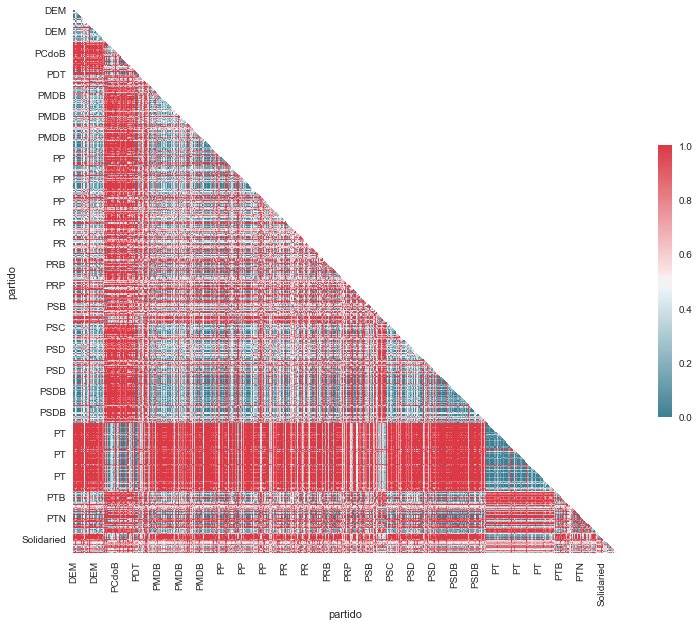

In [279]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


def plot_distances(distances, labels, ticklabels=True):
    
    sns.set(style="white")

    # Generate a large random dataset
    rs = np.random.RandomState(33)
    dists_df = pd.DataFrame(data=distances, columns=labels, index=labels)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(dists_df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(dists_df, mask=mask, cmap=cmap, #vmax=.3,
                square=True, xticklabels=ticklabels, yticklabels=ticklabels,
                cbar_kws={"shrink": .5}, ax=ax)

votos.sort_values(['partido', 'uf'], inplace=True)
dists = pairwise_distances(votos[features].values)
plot_distances(dists, votos.partido, ticklabels=20)

### Cenário político: Brasil x EUA

![Brasil x EUA](images/politics-matrix-comp.png)

### Agregando votos por partido

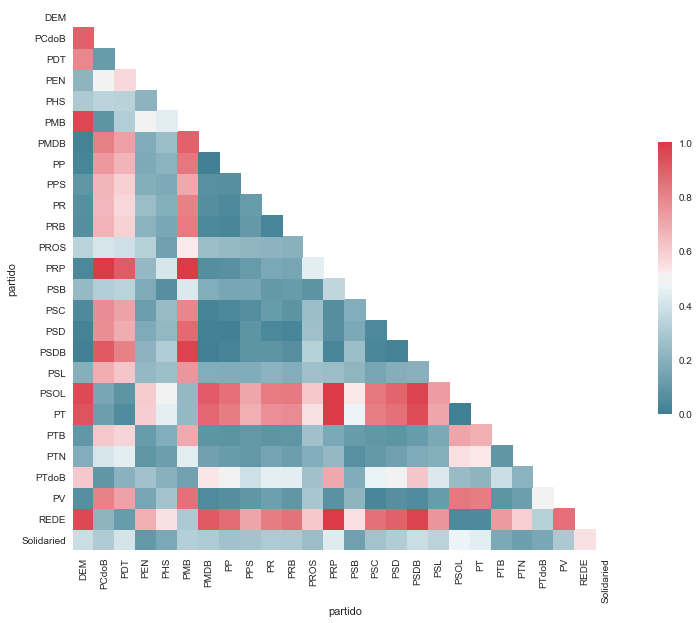

In [280]:
votos_partido = votos.groupby('partido').mean()
dists = pairwise_distances(votos_partido.values, metric='cosine')
plot_distances(dists, votos_partido.index)

### Principal Component Analysis (PCA)

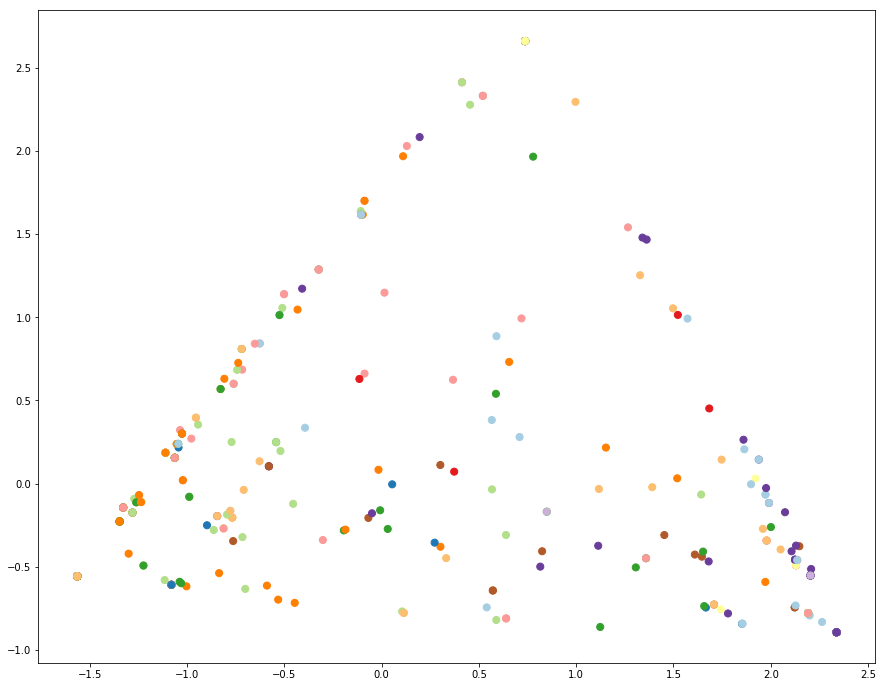

In [10]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
labels = le.fit_transform(votos['partido'])

X_pca = PCA(n_components=2).fit_transform(votos[features])

plt.figure(figsize=(15, 12))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=50, cmap=plt.cm.Paired)

### t-Distributed Stochastic Neighbor Embedding (t-SNE)

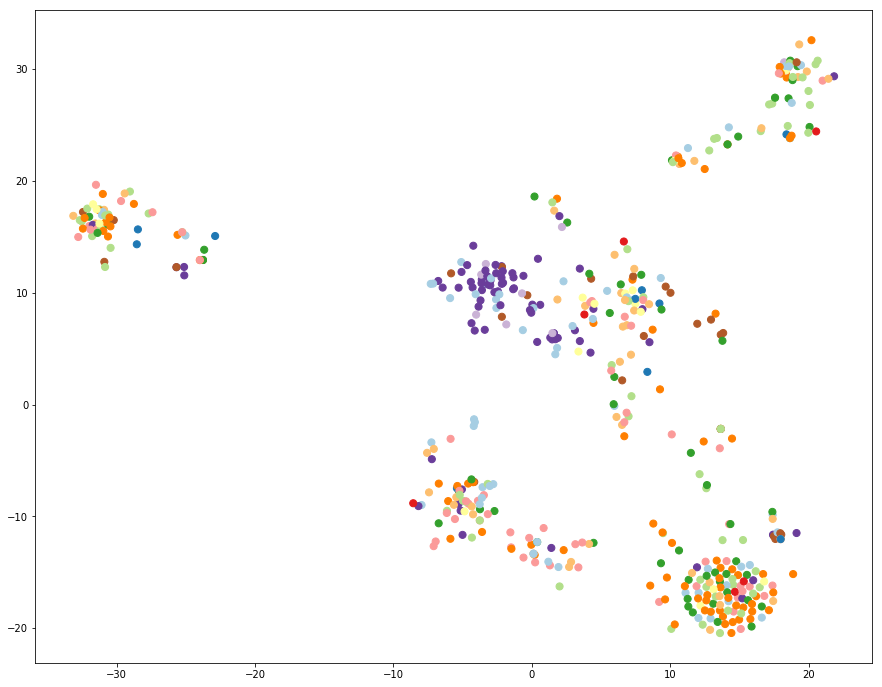

In [9]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn import preprocessing
%matplotlib inline

le = preprocessing.LabelEncoder()
labels = le.fit_transform(votos['partido'])

features = votos.columns.drop(['uf', 'nome', 'partido']).tolist()
X_tsne = TSNE(random_state=42, n_iter=2000, perplexity=50).fit_transform(votos[features])

plt.figure(figsize=(15, 12))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, s=50, cmap=plt.cm.Paired)

### Ferramenta: Embedding Projector
Gerando arquivos para visualização no [Embedding Projector](http://projector.tensorflow.org).

In [15]:
pd.DataFrame(votos[categorical]).to_csv('votos.tsv', sep='\t', index=False)
pd.DataFrame(votos[['nome', 'partido', 'uf']]).to_csv('votos_meta.tsv', sep='\t', index=False)

## Clusterização: medindo a coesão partidária

In [291]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=5, random_state=1).fit(votos[features])

labels = kmeans_model.labels_

clusters = pd.crosstab(votos["partido"], labels)
clusters

col_0,0,1,2,3,4
partido,,,,,
DEM,2,6,19,3,0
PCdoB,8,0,0,2,2
PDT,0,0,1,6,13
PEN,1,1,1,0,0
PHS,2,2,2,1,0
PMB,1,0,0,0,0
PMDB,5,18,34,7,0
PP,6,9,26,6,0
PPS,2,3,4,0,0


In [292]:
clusters.sum()

col_0
0     77
1     96
2    195
3     70
4     76
dtype: int64

### Coesão = percentual de votantes concentrados no cluster mais significativo

In [304]:
def coesao(clusters):
    return np.max(clusters)/np.sum(clusters)

clusters.apply(lambda x: coesao(x), axis=1).sort_values(ascending=False)

partido
PRP           1.000000
PMB           1.000000
PSOL          1.000000
REDE          1.000000
PT            0.879310
PTdoB         0.750000
PCdoB         0.666667
PDT           0.650000
PSDB          0.638298
DEM           0.633333
PSC           0.600000
PP            0.553191
PMDB          0.531250
PSL           0.500000
PV            0.500000
Solidaried    0.500000
PSD           0.459459
PPS           0.444444
PR            0.410256
PROS          0.400000
PTB           0.388889
PTN           0.384615
PRB           0.347826
PEN           0.333333
PSB           0.323529
PHS           0.285714
dtype: float64

## Próximos passos / desafios
* Implementar um sistema de recomendação de parlamentares com base no "vetor político"
* Seria possível justificar estatísticamente uma diminuição no número de partidos?